# Fraud Detection Work

## Introduction and Motivation

The following code is intended for the final year project 'Machine Learning for Credit Card Fraud Detection' by Michael Brozhko.

### Combine CSVs of Dataset

Initially, the dataset uses was already pre split into training and testing data. However, for this experiment to be conducted with high validity, I recombined the dataset and randomly split later to ensure result reliability.

In [ ]:
import os

# The following code is intended to combine the two csv files associated with the dataset in use. 
# The dataset should be randomly split into testing and training data, as it is unclear how it was initially split

os.chdir("/Users/michael/Documents/Aston/FYP/Dataset")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

### Import Libraries

In [1]:
#import relevant libaries

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import datetime as dt
import matplotlib.pyplot as plt
import pickle
import xgboost as xgb
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

from sklearn.svm import SVC
from IPython import display
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, Normalizer
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Load Dataset

Load the dataset into a pandas dataframe and output the data types

In [2]:
# load dataset into a new dataframe and show head
df = pd.read_csv("combined_csv.csv")
# List the initial datatypes of columns in dataframe
print(df.dtypes)
df.head()

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


## Data Preprocessing

In the data preprocessing stage we deal with:
    -Type conversions
    -Removal of unnecessary data
    -Reformatting of data to more model-friendly format

### Check For Null Values

In [3]:
print("Null values by column\n", df.isnull().sum())

Null values by column
 Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


### Datetime Column Seperation

This segment deals with seperating the datetime column into seperate columns - year, hour, day, month. 
There may be a correlation between different times of day, different days and different months with fraudulent activity.

In [4]:
#The following functionality aims to seperate the datetime column
#so that it can be processed as multiple features
#   -This can offer greater performance
#   -Allow the identification of trends with regards to specific days, time of day, etc

#define several empty lists for following functionality
df['age']=dt.date.today().year-pd.to_datetime(df['dob']).dt.year
df['hour']=pd.to_datetime(df['trans_date_trans_time']).dt.hour
df['day']=pd.to_datetime(df['trans_date_trans_time']).dt.dayofweek
df['month']=pd.to_datetime(df['trans_date_trans_time']).dt.month

df.dtypes

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
age                        int64
hour                       int64
day                        int64
month                      int64
dtype: object

### Feature Creation

In [5]:
# Add a feature that calculates the distance between the merchant and the customer for each transaction
df['merchant_customer_distance'] = np.sqrt((df['lat'] - df['merch_lat'])**2 + (df['long'] - df['merch_long'])**2)

# Add a feature that calculates the total amount spent by each credit card
df['total_spent'] = df.groupby('cc_num')['amt'].transform('sum')

df.dtypes

Unnamed: 0                      int64
trans_date_trans_time          object
cc_num                          int64
merchant                       object
category                       object
amt                           float64
first                          object
last                           object
gender                         object
street                         object
city                           object
state                          object
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
job                            object
dob                            object
trans_num                      object
unix_time                       int64
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month       

### Removal of Unnecessary Features

In [6]:
df = df.drop(['Unnamed: 0','cc_num','trans_date_trans_time','first','street','last','trans_num','dob','merchant', 'unix_time'],axis=1)

In [7]:
print(df['state'].nunique())
print(df['city'].nunique())
print(df['job'].nunique())
print(df['category'].nunique())

51
906
497
14


In [7]:
df = df.drop(['city','job'],axis=1)
df.dtypes

category                       object
amt                           float64
gender                         object
state                          object
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month                           int64
merchant_customer_distance    float64
total_spent                   float64
dtype: object

### Feature and Label Seperation

In [8]:
# #labels (y) are the what we are trying to predict and as such, is the 'is_fraud' column
# y=dfn_more['is_fraud'].values
# #format data and for features (X) remove 'is_fraud' column since this is what we are trying to predict
# X=dfn_more.drop(['is_fraud'], axis='columns')

train_data, test_data = train_test_split(df, test_size=0.33, random_state=42)

train_data.dtypes

category                       object
amt                           float64
gender                         object
state                          object
zip                             int64
lat                           float64
long                          float64
city_pop                        int64
merch_lat                     float64
merch_long                    float64
is_fraud                        int64
age                             int64
hour                            int64
day                             int64
month                           int64
merchant_customer_distance    float64
total_spent                   float64
dtype: object

### Feature Encoding

Encoding categorical features

In [9]:
from sklearn.preprocessing import OneHotEncoder

#The following column deals with data preprocessing involving:
#   -Type conversions
#   -Removal of unnecessary data
#   -Reformatting of data to more model-friendly format

# Define the columns to encode
columns_to_encode = ['state', 'gender','category']

# Create an instance of the encoder
encoder = OneHotEncoder()

# Fit the encoder to the training data for the selected columns
encoder.fit(train_data[columns_to_encode])

# Apply the encoder to the training and test data for the selected columns
train_data_encoded = encoder.transform(train_data[columns_to_encode])
test_data_encoded = encoder.transform(test_data[columns_to_encode])

# Get the names of the encoded columns
encoded_column_names = encoder.get_feature_names(columns_to_encode)

# Create new DataFrames for the encoded columns
train_data_encoded_df = pd.DataFrame(train_data_encoded.toarray(), columns=encoded_column_names)
test_data_encoded_df = pd.DataFrame(test_data_encoded.toarray(), columns=encoded_column_names)

# Drop the original columns from the training and test data
train_data = train_data.drop(columns_to_encode, axis=1)
test_data = test_data.drop(columns_to_encode, axis=1)

# Concatenate the encoded columns with the remaining columns
train_data = pd.concat([train_data, train_data_encoded_df], axis=1)
test_data = pd.concat([test_data, test_data_encoded_df], axis=1)

/Users/michael/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [10]:
with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        'display.precision', 3,
                        ):
    print(train_data.dtypes)

amt                           float64
zip                           float64
lat                           float64
long                          float64
city_pop                      float64
merch_lat                     float64
merch_long                    float64
is_fraud                      float64
age                           float64
hour                          float64
day                           float64
month                         float64
merchant_customer_distance    float64
total_spent                   float64
state_AK                      float64
state_AL                      float64
state_AR                      float64
state_AZ                      float64
state_CA                      float64
state_CO                      float64
state_CT                      float64
state_DC                      float64
state_DE                      float64
state_FL                      float64
state_GA                      float64
state_HI                      float64
state_IA    

In [11]:
train_data.head()

,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
2768116,65.57,4616.0,44.2541,-68.5565,824.0,43.294795,-68.718689,0.0,49.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2144879,89.78,23937.0,36.9688,-78.5615,1970.0,36.004118,-78.382052,0.0,38.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1122045,22.99,28405.0,34.2651,-77.8670,186140.0,34.565603,-77.762061,0.0,40.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
811251,8.70,36775.0,32.2844,-86.9920,800.0,31.737033,-87.710055,0.0,91.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
899749,17.97,52572.0,40.6866,-92.6833,1132.0,40.340462,-92.348096,0.0,62.0,20.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
train_data=train_data.dropna()
train_data.head()


,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
2768116,65.57,4616.0,44.2541,-68.5565,824.0,43.294795,-68.718689,0.0,49.0,23.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2144879,89.78,23937.0,36.9688,-78.5615,1970.0,36.004118,-78.382052,0.0,38.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1122045,22.99,28405.0,34.2651,-77.8670,186140.0,34.565603,-77.762061,0.0,40.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
811251,8.70,36775.0,32.2844,-86.9920,800.0,31.737033,-87.710055,0.0,91.0,7.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
899749,17.97,52572.0,40.6866,-92.6833,1132.0,40.340462,-92.348096,0.0,62.0,20.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
test_data=test_data.dropna()
test_data.head()

,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,age,hour,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
299520,37.58,52535.0,40.8626,-91.9534,888.0,40.781342,-92.768611,0.0,35.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1725905,49.80,67584.0,38.6411,-100.1380,269.0,39.015727,-100.089812,0.0,61.0,4.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
389829,42.86,57732.0,44.3566,-103.6999,1979.0,45.088857,-103.720708,0.0,53.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118075,4.33,70774.0,30.2385,-90.8435,10076.0,29.881234,-90.980444,0.0,46.0,15.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1184622,136.12,43408.0,41.5686,-83.3632,269.0,42.343209,-82.738339,0.0,58.0,6.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
y_train=train_data['is_fraud']
X_train=train_data.drop(['is_fraud'], axis='columns')

y_test=test_data['is_fraud']
X_test=test_data.drop(['is_fraud'], axis='columns')

### Outlier Detection and Removal

In [ ]:
# Calculate the correlation coefficient between 'amount' and 'is_fraud'
corr = dfn['amt'].corr(dfn['is_fraud'])

# Print the correlation coefficient
print("Correlation Coefficient:", corr)

Correlation Coefficient: 0.2093078472298056


In [ ]:
print(dfn['day'].nunique())
print(dfn['month'].nunique())

7
12


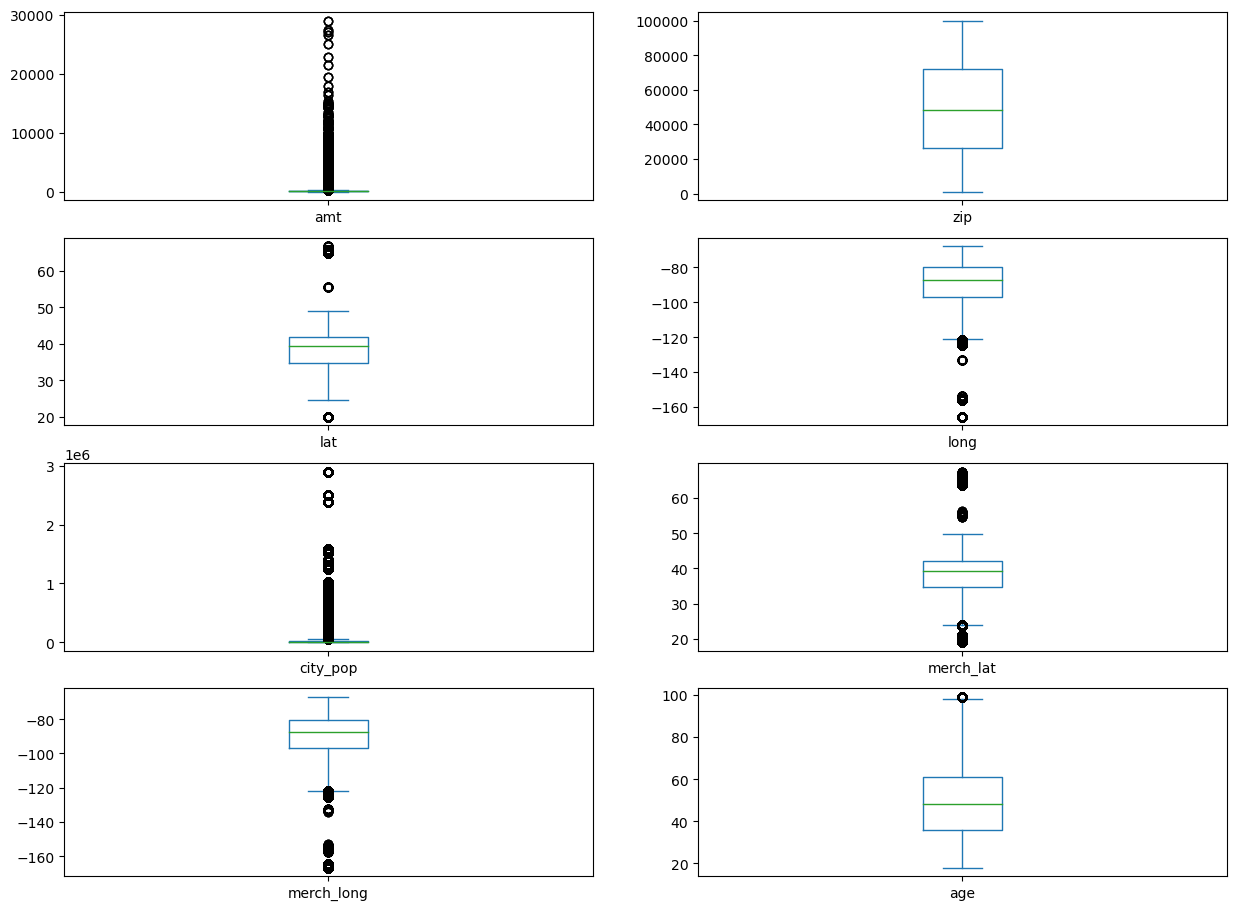

In [ ]:
data = dfn[['amt','zip','lat','long','city_pop','merch_lat','merch_long','age']]
data.plot(kind="box",subplots=True,layout=(7,2),figsize=(15,20));

In [ ]:
def get_min_max_no_outliers(df, col1, col2):
    # Calculate the interquartile range (IQR) for each column
    Q1 = df[[col1, col2]].quantile(0.25)
    Q3 = df[[col1, col2]].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    outlier_threshold = 1.5

    # Define non-outlier range for each column
    min_val = Q1 - outlier_threshold * IQR
    max_val = Q3 + outlier_threshold * IQR

    # Filter the DataFrame to exclude outliers
    df_filtered = df[(df[col1] >= min_val[col1]) & (df[col1] <= max_val[col1]) &
                     (df[col2] >= min_val[col2]) & (df[col2] <= max_val[col2])]

    print("Minimum Values:\n",df_filtered[[col1, col2]].min())
    print("Maximum Values:\n",df_filtered[[col1, col2]].max())

get_min_max_no_outliers(dfn, 'age', 'amt')

Minimum Values:
 age    18.0
amt     1.0
dtype: float64
Maximum Values:
 age     98.00
amt    193.29
dtype: float64


In [ ]:
print(len(dfn))
dfn = dfn[dfn['age']<=98]
print(len(dfn))

5557182
5554977


Fraudulent:  28932
Non-fraudulent:  5526045


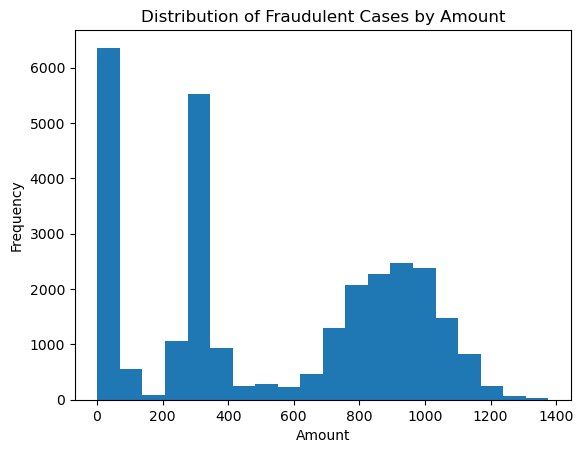

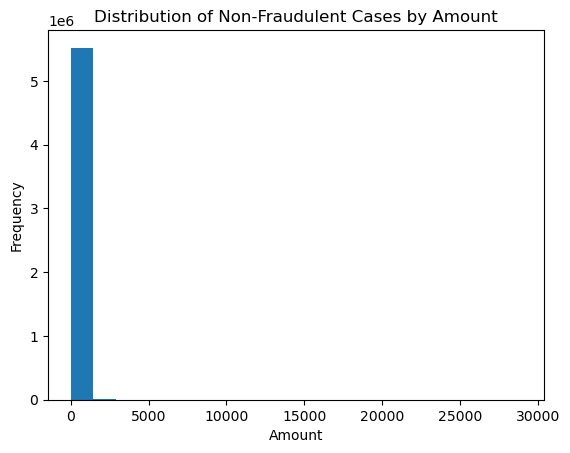

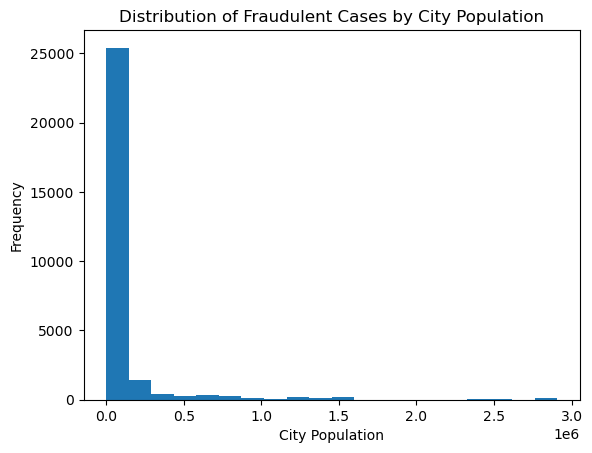

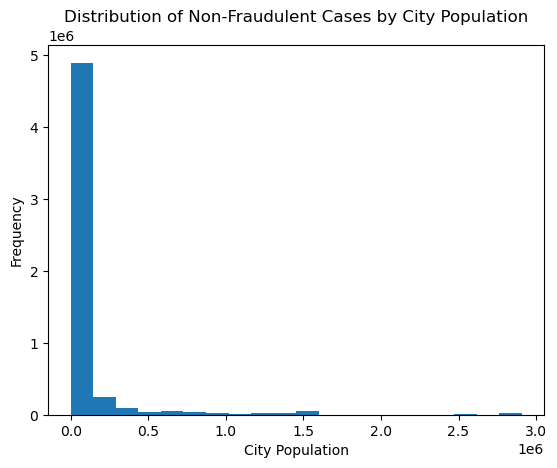

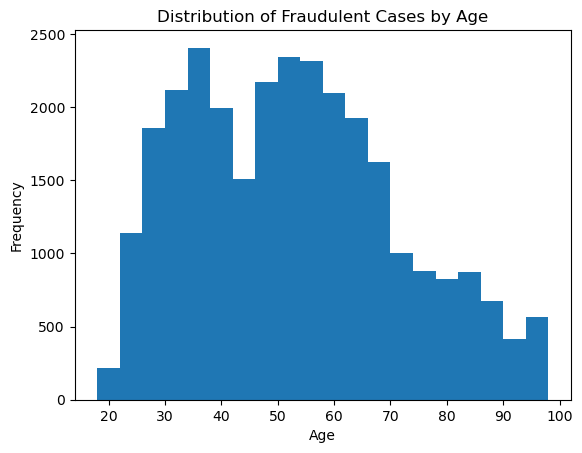

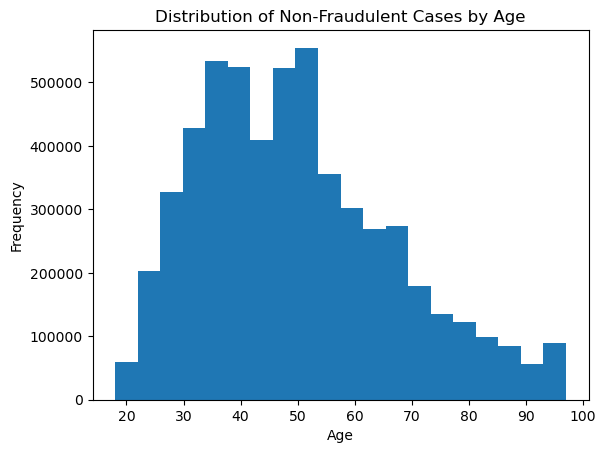

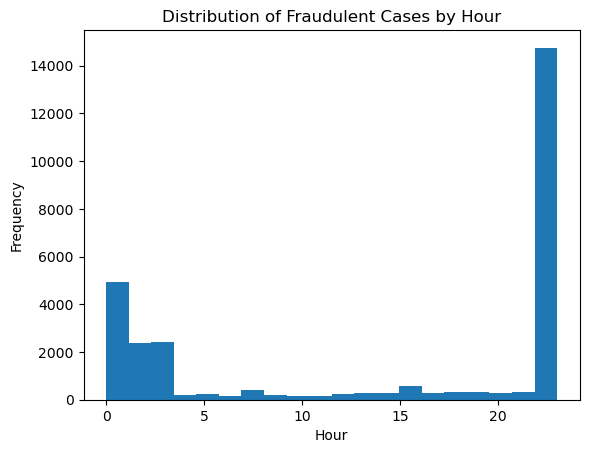

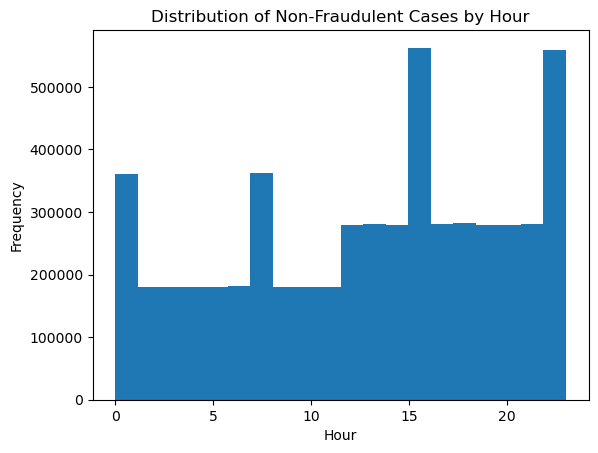

In [ ]:
fraud_df = dfn[dfn['is_fraud'] == 1]
nonFraud_df = dfn[dfn['is_fraud'] == 0]

print("Fraudulent: ",len(fraud_df))
print("Non-fraudulent: ",len(nonFraud_df))

def plotGraphs(bins):
    
    plt.hist(fraud_df['amt'], bins=bins)
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraudulent Cases by Amount')
    plt.show()
    
    plt.hist(nonFraud_df['amt'], bins=bins)
    plt.xlabel('Amount')
    plt.ylabel('Frequency')
    plt.title('Distribution of Non-Fraudulent Cases by Amount')
    plt.show()
    
    plt.hist(fraud_df['city_pop'], bins=bins)
    plt.xlabel('City Population')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraudulent Cases by City Population')
    plt.show()
    
    plt.hist(nonFraud_df['city_pop'], bins=bins)
    plt.xlabel('City Population')
    plt.ylabel('Frequency')
    plt.title('Distribution of Non-Fraudulent Cases by City Population')
    plt.show()
    
    plt.hist(fraud_df['age'], bins=bins)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraudulent Cases by Age')
    plt.show()
    
    plt.hist(nonFraud_df['age'], bins=bins)
    plt.xlabel('Age')
    plt.ylabel('Frequency')
    plt.title('Distribution of Non-Fraudulent Cases by Age')
    plt.show()
    
    plt.hist(fraud_df['hour'], bins=bins)
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.title('Distribution of Fraudulent Cases by Hour')
    plt.show()
    
    plt.hist(nonFraud_df['hour'], bins=bins)
    plt.xlabel('Hour')
    plt.ylabel('Frequency')
    plt.title('Distribution of Non-Fraudulent Cases by Hour')
    plt.show()
    
plotGraphs(20)

In [16]:
X_train.dtypes

amt                       float64
zip                       float64
lat                       float64
long                      float64
city_pop                  float64
                           ...   
category_misc_pos         float64
category_personal_care    float64
category_shopping_net     float64
category_shopping_pos     float64
category_travel           float64
Length: 80, dtype: object

### Scaling Data

A standard scaler is used to standerdise the data with the normal distribution with mean = 0

In [18]:
# #scale the data 

# def scaling(X):
#     sc = StandardScaler()
#     X['amt'] = sc.fit_transform(X[['amt']])
#     X['zip'] = sc.fit_transform(X[['zip']])
#     X['lat'] = sc.fit_transform(X[['lat']])
#     X['long'] = sc.fit_transform(X[['long']])
#     X['city_pop'] = sc.fit_transform(X[['city_pop']])
#     X['merch_lat'] = sc.fit_transform(X[['merch_lat']])
#     X['merch_long'] = sc.fit_transform(X[['merch_long']])
#     X['hour'] = sc.fit_transform(X[['hour']])
#     X['day'] = sc.fit_transform(X[['day']])
#     X['month'] = sc.fit_transform(X[['month']])
#     X['age'] = sc.fit_transform(X[['age']])
#     X['merchant_customer_distance'] = sc.fit_transform(X[['merchant_customer_distance']])
#     X['total_spent'] = sc.fit_transform(X[['total_spent']])
#     return X

In [16]:
# X_train = scaling(X_train)
# X_test = scaling(X_test)

X_train.head()

,amt,zip,lat,long,city_pop,merch_lat,merch_long,age,hour,day,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
2768116,65.57,4616.0,44.2541,-68.5565,824.0,43.294795,-68.718689,49.0,23.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2144879,89.78,23937.0,36.9688,-78.5615,1970.0,36.004118,-78.382052,38.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1122045,22.99,28405.0,34.2651,-77.8670,186140.0,34.565603,-77.762061,40.0,14.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
811251,8.70,36775.0,32.2844,-86.9920,800.0,31.737033,-87.710055,91.0,7.0,5.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
899749,17.97,52572.0,40.6866,-92.6833,1132.0,40.340462,-92.348096,62.0,20.0,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Principle Component Analysis

In [20]:
def pca_analysis(features):
    scaled = StandardScaler(features)
    cs = features.columns
    pca = PCA()
    pca.fit(scaled)
    values = pca.explained_variance_ratio_

    result = pd.DataFrame(data=[values],columns=cs)

    with pd.option_context('display.max_rows', None,
                           'display.max_columns', None,
                           'display.precision', 3,
                           ):
        print(result)
    
pca_analysis(X_train)

TypeError: __init__() takes 1 positional argument but 2 were given

In [ ]:
pd.options.display.max_rows = 4000
pd.set_option('display.max_colwidth', None)

### Final Column Selection

Based on PCA results certain features are selected while others are discarded

In [17]:
X_train = X_train[['amt','zip','lat','long','age','hour','merch_lat','merch_long','day','month']]
X_test = X_test[['amt','zip','lat','long','age','hour','merch_lat','merch_long','day','month']]


In [18]:
X_train.head()

,amt,zip,lat,long,age,hour,merch_lat,merch_long,day,month
2768116,65.57,4616.0,44.2541,-68.5565,49.0,23.0,43.294795,-68.718689,6.0,12.0
2144879,89.78,23937.0,36.9688,-78.5615,38.0,4.0,36.004118,-78.382052,4.0,5.0
1122045,22.99,28405.0,34.2651,-77.8670,40.0,14.0,34.565603,-77.762061,6.0,4.0
811251,8.70,36775.0,32.2844,-86.9920,91.0,7.0,31.737033,-87.710055,5.0,12.0
899749,17.97,52572.0,40.6866,-92.6833,62.0,20.0,40.340462,-92.348096,3.0,12.0


## Key Functions

### plotResults()
The following function is defined to plot results based on a parameter 'report' which is a passed classification report

In [19]:
def plotResults(report,model):
    df = pd.DataFrame(report)
    df.iloc[:3, :2].T.plot(kind='bar')
    plt.title(model)
    plt.xlabel('Class')
    plt.ylabel('Performance')
    plt.show()

### PlotLearning()

Plot the learning curve for specific model train and test scores

In [20]:
from sklearn.model_selection import learning_curve

def plotLearning(model, X, y):
    
    # Define the training set sizes to use for the learning curve
    train_sizes = np.linspace(0.1, 1.0, 5)

    # Calculate the learning curve
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, train_sizes=train_sizes, scoring='accuracy')

    # Calculate the mean and standard deviation of the training and test scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation testing score')

    # Add error bars showing the standard deviation of the scores
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    # Add labels and legend to the plot
    plt.xlabel('Training set size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()

In [44]:
from sklearn.metrics import make_scorer, recall_score, precision_score

def modelPerformance(pipe, name, parameters,X_train,y_train,X_test,y_test):

    # Perform hyperparameter tuning using GridSearchCV and the validation set
    scorer = make_scorer(precision_score,pos_label=1)
    grid_search = GridSearchCV(pipe, parameters, cv=5,scoring=scorer)
    grid_search.fit(X_train, y_train)
    
    print(name,': ',grid_search.best_params_)

    best_estimator = grid_search.best_estimator_
    best_estimator.fit(X_train, y_train)

    print(name," best estimator fitted")
    
    Y_trainPred = best_estimator.predict(X_train)
    print(name," Train Accuracy: ",accuracy_score(y_train, Y_trainPred))
    print(name," Train Scores\n",classification_report(y_train, Y_trainPred))
    
    Y_testPred = best_estimator.predict(X_test)
    print(name," Test Accuracy: ",accuracy_score(y_test, Y_testPred))
    print(name," Test Scores\n",classification_report(y_test, Y_testPred))

    plotResults(classification_report(y_train, Y_trainPred, digits=4,  output_dict=True),name+' Classifier Train Score')
    plotResults(classification_report(y_test, Y_testPred, digits=4,  output_dict=True),name+' Classifier Test Score')
    

### RunModels()

Main function called to run the desired Machine Learning models on specified parameters for features (X) and labels (y)

This function makes calls to the various prior defined functions.

Certain models are commented out/in for testing purposes. For reviewing models, comment/uncomment different code blocks.

In [45]:
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as imbpipeline

# Function to run models

# Avoids code repitiion by encapsulating all functionality in the function, allowing models on different data splits 
# and sample sizes to be run by calling function and passing relevamt parameters


# The function takes the features (x), labels (y) and text (t) as parameters
# Performs:
#     1. Train-testing data split
#     2. Model training and testing
#     3. Output of performance metrics through classification_report

# The function does not return anything

def runModels(X_train,y_train,X_test,y_test):
    samplers = [None,RandomUnderSampler(),SMOTE()]
    
    # parameters = {
    #     'sampling': samplers,
    #     'knn__n_jobs': [-1],
    #     'knn__weights': ['distance'],
    #     'knn__n_neighbors': [5,6]
    # }
    
    # knnPipe = imbpipeline([
    #     ('sampling',None),
    #     ('scaler', StandardScaler()),
    #     ('knn', KNeighborsClassifier())
    # ])

    # modelPerformance(knnPipe,'KNN',parameters,X_train,y_train,X_test,y_test)
    

    parameters = {
        'sampling': samplers,
        'xgb__n_jobs': [-1],
        'xgb__min_child_weight': [1],
        'xgb__objective': ['binary:logistic'],
        'xgb__reg_alpha': [0.1],
        'xgb__reg_lambda': [0.1],
        'xgb__max_depth': [15,25],
        'xgb__learning_rate': [0.05, 0.1],
        'xgb__n_estimators': [150,200]
    }

    xgbPipe = imbpipeline([
        ('sampling',None),
        ('scaler', StandardScaler()),
        ('xgb', xgb.XGBClassifier())
    ])

    modelPerformance(xgbPipe,'XGB' ,parameters,X_train,y_train,X_test,y_test)
    
    # parameters = {
    #     'sampling': samplers,
    #     'rf__n_jobs': [-1],
    #     'rf__n_estimators': [150, 200],
    #     'rf__max_depth': [15,25]
    # }

    # rfPipe = imbpipeline([
    #     ('sampling',None),
    #     ('scaler', StandardScaler()),
    #     ('rf', RandomForestClassifier())
    # ])

    # modelPerformance(rfPipe,'Random Forest', parameters,X_train,y_train,X_test,y_test)

    # parameters = {
    #     'sampling': samplers,
    #     'mlp__early_stopping': [True],
    #     'mlp__max_iter': [1200],
    #     'mlp__hidden_layer_sizes': [(50, 50), (200, 150), (80,100,80)],
    #     'mlp__alpha': [0.0001,0.001, 0.01]
    # }
    
    # mlpPipe = imbpipeline([
    #     ('sampling',None),
    #     ('scaler', StandardScaler()),
    #     ('mlp', MLPClassifier())
    # ])

    # modelPerformance(mlpPipe,'MLP', parameters,X_train,y_train,X_test,y_test)


## Results

Results analysis using the above functions is conducted on the data obtained from a variety of different sampling models as-well as the unsampled dataset

### Unsampled Data

Calculate prediction and analysis of results based on the unsampled data

KNN :  {'knn__n_jobs': -1, 'knn__n_neighbors': 6, 'knn__weights': 'distance', 'sampling': None}
KNN  best estimator fitted
KNN  Train Accuracy:  1.0
KNN  Train Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   2481790
         1.0       1.00      1.00      1.00     12927

    accuracy                           1.00   2494717
   macro avg       1.00      1.00      1.00   2494717
weighted avg       1.00      1.00      1.00   2494717

KNN  Test Accuracy:  0.9988361443313285
KNN  Test Scores
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    601663
         1.0       0.94      0.84      0.88      3223

    accuracy                           1.00    604886
   macro avg       0.97      0.92      0.94    604886
weighted avg       1.00      1.00      1.00    604886



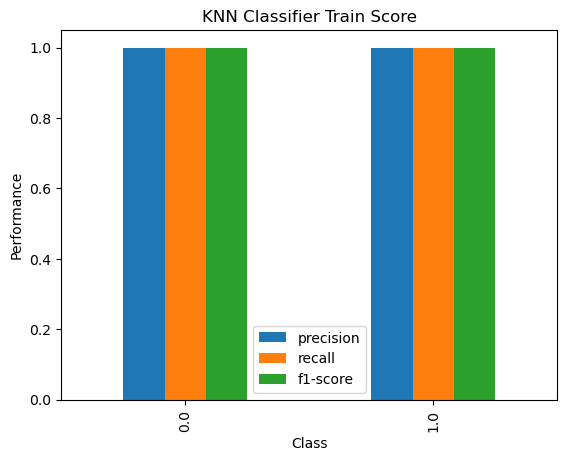

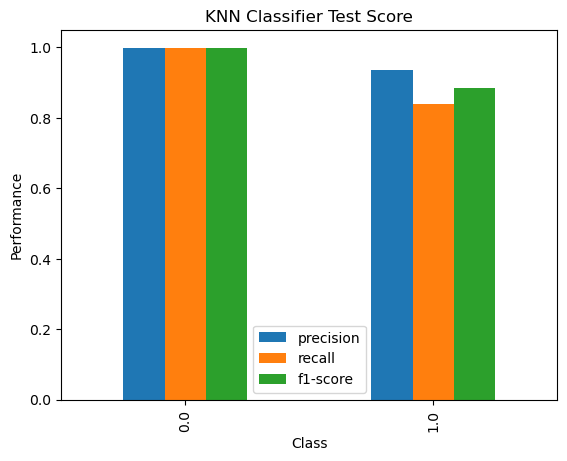

In [46]:
#Run Models
runModels(X_train,y_train,X_test,y_test)

### SMOTE - Systematic Minority Oversampling

SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

For this experiment, we will oversample the data in ratios 1:1, 10:1 and 100:1 
Since the undersampled data was at ratio 368546:19302 majority class to minority class, smote will scale up the number of datapoints for the minority class to match the above ratios.

Performance metrics for Systematic Majority Oversampling 1:1 data
Counter({0: 5528229, 1: 5528229})
(7407826, 13)
(7407826,)
(3648632, 13)
(3648632,)
              precision    recall  f1-score   support

           0       0.80      0.95      0.87   1824316
           1       0.93      0.76      0.84   1824316

    accuracy                           0.85   3648632
   macro avg       0.87      0.85      0.85   3648632
weighted avg       0.87      0.85      0.85   3648632



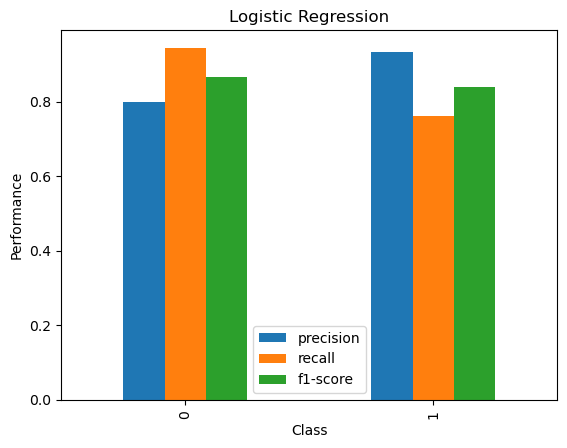

              precision    recall  f1-score   support

           0       0.69      0.99      0.81   1824316
           1       0.98      0.55      0.71   1824316

    accuracy                           0.77   3648632
   macro avg       0.83      0.77      0.76   3648632
weighted avg       0.83      0.77      0.76   3648632



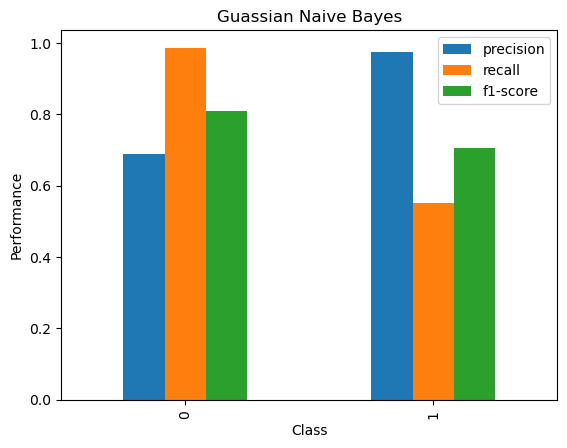

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1824316
           1       1.00      1.00      1.00   1824316

    accuracy                           1.00   3648632
   macro avg       1.00      1.00      1.00   3648632
weighted avg       1.00      1.00      1.00   3648632



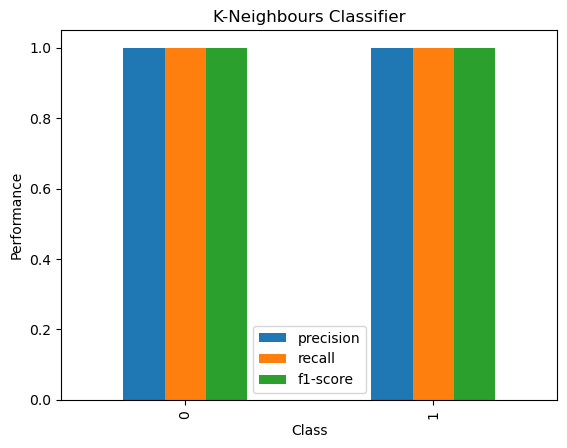

              precision    recall  f1-score   support

           0       0.99      0.98      0.99   1824316
           1       0.98      0.99      0.99   1824316

    accuracy                           0.99   3648632
   macro avg       0.99      0.99      0.99   3648632
weighted avg       0.99      0.99      0.99   3648632



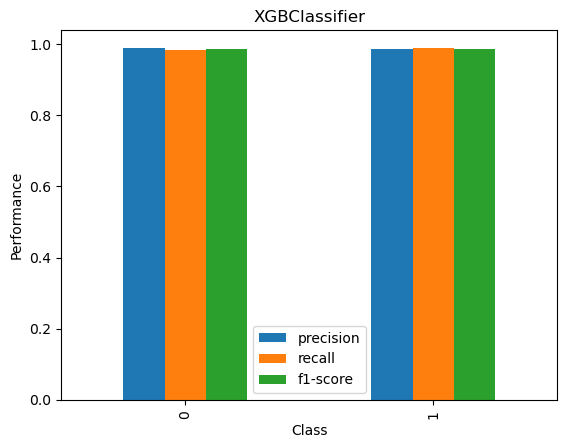

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1824316
           1       1.00      1.00      1.00   1824316

    accuracy                           1.00   3648632
   macro avg       1.00      1.00      1.00   3648632
weighted avg       1.00      1.00      1.00   3648632



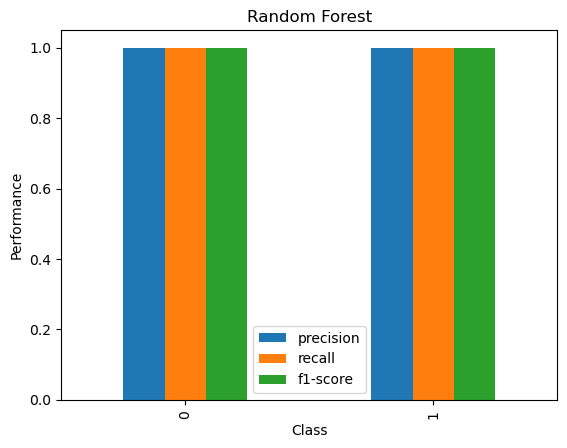

In [ ]:
smote2 = SMOTE(random_state=42, sampling_strategy={1:368549})
X_smote2, y_smote2 = smote2.fit_resample(X, y)
runModels(X_smote2, y_smote2, "Systematic Majority Oversampling 10:1")

# smote3 = SMOTE(random_state=42, sampling_strategy={1:36855})
# X_smote3, y_smote3  = smote3.fit_resample(X, y)
# runModels(X_smote3, y_smote3, "Systematic Majority Oversampling 100:1")

### Random Undersampling

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. This has the effect of reducing the number of examples in the majority class in the transformed version of the training dataset.

For this experiment, we will undersample the data in ratios 1:1, 10:1 and 100:1 Since the data was at ratio 368546:19302 majority class to minority class, random undersampling will scale down the number of datapoints for the majority class to match the above ratios.

In [ ]:
rus2 = RandomUnderSampler(random_state=42, sampling_strategy={0:190000, 1:19000})
X_under2, y_under2 = rus2.fit_resample(X, y)
runModels(X_under2, y_under2, "Random Undersampling 10:1")

# rus3 = RandomUnderSampler(random_state=42, sampling_strategy={0:1900000, 1:19000})
# X_under3, y_under3 = rus3.fit_resample(X, y)
# runModels(X_under3, y_under3, "Random Undersampling 100:1")

TypeError: runModels() takes 1 positional argument but 3 were given